In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

dataset = pd.read_csv("../data/cleanData.csv")

In [2]:
dataset.head(5)

,Unnamed: 0,accession_number,artist,title,date,decade,country,collection,sight,length,...,abrasions_frame,flaking_frame,losses_frame,dented_frame,chipped_frame,cracking_frame,corner_damage_frame,mitres_separating_frame,work_loose_frame,surface_dirt_along_top_edge_frame
0,0,Upvma-Iii.00240,"Gallardo, Alladin",Ifugao Warrior,1947,1940,Philippines,Vargas Museum (Philippines),635X 480,635.00,...,1,0,1,1,1,0,1,0,0,0
1,1,Upvma-Iii.00085,"Ancheta, Isidro",Guadalupe Ruins,1939,1930,Philippines,Vargas Museum (Philippines),670 X 405,670.00,...,1,0,0,1,0,0,1,0,0,0
2,2,Upvma-Iii.00292\n,"Lagniton, Jose",3:00 O'Clock Seascape,1948,1940,Philippines,Vargas Museum (Philippines),320 X 370,320.00,...,1,0,0,1,1,0,0,1,0,0
3,3,Upvma-Iii.00126\n,"Buenaventura Y Espana, Oscar","Kabulusan Beach, Laguna De Bay",1947,1940,Philippines,Vargas Museum (Philippines),400 X 500,400.00,...,1,0,0,1,0,0,0,0,0,0
4,4,Upvma-Iii.00161\n,"Cristobal, Bonifacio",Bsp President Jorge B. Vargas,1950,1950,Philippines,Vargas Museum (Philippines),725-727 X 601,727.00,...,1,0,0,1,1,0,1,0,0,0


Predicting `ground_layer_application`

In [3]:
colnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 
            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']

One hot encode categorical data with more than two values

In [4]:
prediction_set = dataset[colnames]
one_hot = pd.get_dummies(prediction_set['ground_layer_limit'])
prediction_set = prediction_set.drop('ground_layer_limit', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_layer_thickness'])
prediction_set = prediction_set.drop('ground_layer_thickness', axis=1)
prediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")

one_hot = pd.get_dummies(prediction_set['collection'])
prediction_set = prediction_set.drop('collection', axis=1)
prediction_set = prediction_set.join(one_hot)

Split data into training, validation and testing set

In [5]:
temp = prediction_set[(prediction_set['ground_layer_application'] != 'Unspecified') & (prediction_set['ground_layer_application'] != 'Unsure')]
train = temp.sample(frac = 0.8, random_state=25)
valid = temp.drop(train.index)
test = prediction_set[(prediction_set['ground_layer_application'] == 'Unspecified') | (prediction_set['ground_layer_application'] == 'Unsure')]

In [6]:
X_train = train.drop('ground_layer_application', axis=1)
y_train = train['ground_layer_application']

X_valid = valid.drop('ground_layer_application', axis=1)
y_valid = valid['ground_layer_application']

X_test = test.drop('ground_layer_application', axis=1)

In [7]:
X_train.shape, X_valid.shape

((147, 18), (37, 18))

In [8]:
X_test.shape

(24, 18)

Train baseline model: Bernoulli Naive Bayes

In [9]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [10]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
valid_prediction = bnb.predict(X_valid)
print("Training Accuracy:", bnb.score(X_train, y_train))
print("Holdout Accuracy:", bnb.score(X_valid, y_valid))

Training Accuracy: 0.7891156462585034
Holdout Accuracy: 0.8108108108108109


In [15]:
print("Training data class distribution: ", Counter(y_train))
print("Validation data class distribution: ", Counter(y_valid))
print("Validation prediction distribution: ", Counter(valid_prediction))

Training data class distribution:  Counter({'Artist Applied Ground': 77, 'Commercial Ground': 70})
Validation data class distribution:  Counter({'Commercial Ground': 24, 'Artist Applied Ground': 13})
Validation prediction distribution:  Counter({'Commercial Ground': 23, 'Artist Applied Ground': 14})


Evaluate using confusion matrix

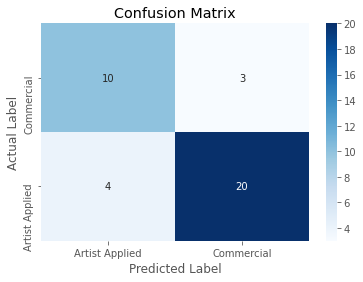

In [18]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Artist Applied', 'Commercial'])
ax.yaxis.set_ticklabels(['Commercial','Artist Applied'])
plt.show()